# SN ZTF23aagdamr 2023-04-20

The first night of looking at this supernova ZTF23aagdamr. Luminance filter only.

In [38]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.coordinates import SkyCoord
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa
import twirl

# Only the following group of constants should need to be adjusted, typically, from one analysis to the next.
observation_date = '2023-04-20'
filters = ['lumi']
filter_full_names = ["Luminance"]
light_exposure = 60 * u.second
flat_exposure = 1 * u.second
BINNING = 2  # 2x2 binning
SUBFRAMING = 2  # For "Half" Subframing
UNBINNED_PLATE_SCALE = 0.239
WIDTH_HEIGHT = (8288, 5644)
BINNED_SUBFRAMED_WIDTH_HEIGHT = tuple([x / BINNING / SUBFRAMING for x in WIDTH_HEIGHT])
plate_scale_raw = UNBINNED_PLATE_SCALE * BINNING
plate_scale = plate_scale_raw * u.arcsec
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.
fov = np.max((8272, 5644)) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value
# Conveniences for referring to filters
LUMI_FILTER = 0

# directories where the observation and calibration images being analyzed are kept
observation_directory = os.path.join(os.path.expanduser('~'), 'Sessions', observation_date)

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        # if pixel_value != pixel_value or pixel_value <= 1.0:
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# Trimmed image reader utility (needed because our images have four columns of NaNs)

def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img

# Imports for Plate-Solving

from astropy.stats import mad_std
from photutils.detection import DAOStarFinder

from astroquery.astrometry_net import AstrometryNet

import keyring

# You will have to uncomment and execute the following (only once) with your actual astrometry.net API key:
# keyring.set_password('astroquery:astrometry_net', None, 'xxxxxxxxxxxxxxxx')
# Your key will be stored privately in the operating system's keychain. Then the following will work:

AstrometryNet.api_key = keyring.get_password('astroquery:astrometry_net', None)

### Load Science and Calibration Images

In [39]:
# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]

lights_list = [[trimmed_image_reader(file) for file in light_files] for light_files in light_files_list]

# the aligned directories are written to not read from
aligned_directory_list = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directory_list:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)


Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [40]:
# Combine darks, flats, and biases

method = 'median'  # the method can be changed to 'average'


### Examine Uncalibrated and Calibrated Images

The displays below are north-down because this object was in the west. The first is with the g' filter and the second is with r'.

Compare with [TheSkyX chart, half-frame, north-down](https://brianhill.github.io/transient-astronomy/targets/SN_2022abik/target/TheSkyXScreenshot-HalfFrame-NorthDown.png).

In [41]:
# First grab some sample uncalibrated lights

sample_lights = [lights[0] for lights in lights_list]
sample_data_list = [np.asarray(sample_light) for sample_light in sample_lights]

# Median subtract

medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data_list]
subtracted = [sample_data_list[i] - medians[i] for i in range(len(filters))]


In [42]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_lights = [transform(data) for data in subtracted]


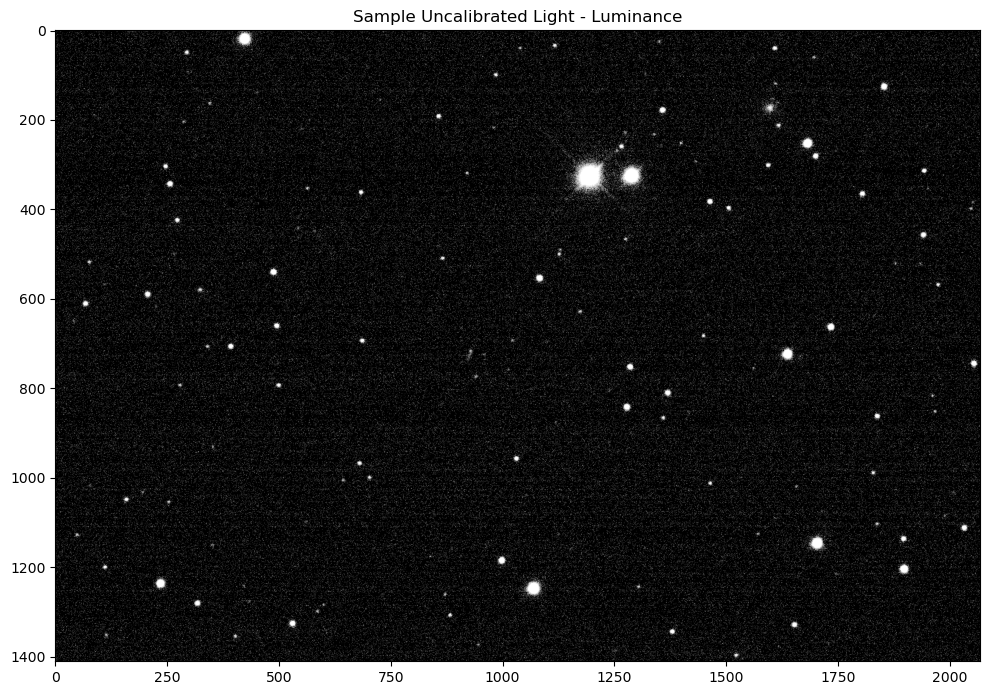

In [43]:
# Display image in three filters

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.imshow(transformed_sample_lights[LUMI_FILTER], cmap='gray')
axes.set_title("Sample Uncalibrated Light - " + filter_full_names[LUMI_FILTER])

plt.tight_layout()
plt.show()

### Create and Write the Aligned Lights

The last step before combining the lights is alignment.

In [44]:
reference_light_list = [lights[0] for lights in lights_list]

lights_aligned_with_footprints_list = [[aa.register(l, reference_light_list[i], detection_sigma=3.0) for
                                        l in lights_list[i]] for i in range(len(filters))]

In [45]:
first_header_list = []

for i in range(len(filters)):
    # First we pick out all the stuff for a given filter
    lights = lights_list[i]
    light_files = light_files_list[i]
    lights_aligned_with_footprints = lights_aligned_with_footprints_list[i]
    aligned_directory = aligned_directory_list[i]
    for j in range(len(lights_aligned_with_footprints)):
        # Then we write all the files for that filter
        light_header = lights[j][0].header
        light_aligned_data = lights_aligned_with_footprints[j][0]
        aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
        aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
        fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)
    first_header_list.append(lights[0][0].header)

### Read Back in and Stack the Lights

In [46]:
# we'll have to do this for each filter, so make some empty lists to append to
first_light_list = []  # this contains the whole first fits file for each filter
combined_light_list = []  # this contains the combined light data for each filter

for i in range(len(filters)):
    aligned_directory = aligned_directory_list[i]
    aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
    first_light_list.append(fits.open(aligned_files[0]))
    lights = [CCDData.read(file, unit=u.adu) for file in aligned_files]
    combined_light_list.append(combine(lights, method=method))

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### Examine the Stacked Lights

In [47]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

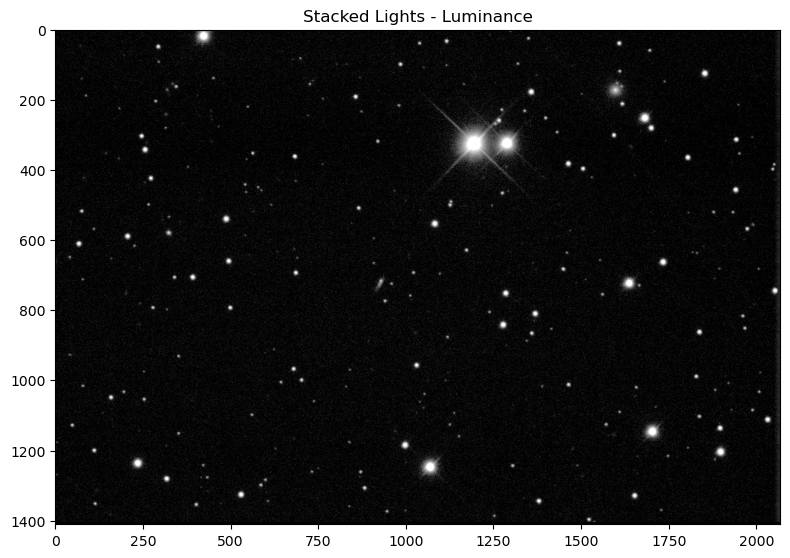

In [48]:
# Stacked Luminance Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[LUMI_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[LUMI_FILTER])

plt.tight_layout()
plt.show()

### Plate-Solve and Write the Stacked Images

I tried to follow the twirl package directions for plate solving ([example notebook](https://github.com/lgrcia/twirl/blob/master/docs/notebooks/example.ipynb))
but got an error I couldn't sort out at 

```
gaias = twirl.gaia_radecs(center, fov/2, limit=20)
```

I'm guessing an API key is needed and without it gaias just comes back as an empty list.

In our first-generation notebooks, we used DAOStarFinder, so let's return to that, and then
try the astrometry.net interface for plate-solving.

#### Get Sources with DAOStarFinder then Plate-Solve with AstrometryNet

We are following the [AstrometryNet](https://astroquery.readthedocs.io/en/latest/astrometry_net/astrometry_net.html)
documentation.

In [49]:
bkg_sigma_list = [mad_std(stacked_data) for stacked_data in stacked_data_list]
daofind = DAOStarFinder(fwhm=4., threshold=5. * bkg_sigma, brightest=100)
sources_list = [daofind(stacked_data) for stacked_data in stacked_data_list]

for sources in sources_list:
    sources.sort('flux')
    sources.reverse()

sources_list[SLOAN_G_FILTER]

NameError: name 'bkg_sigma' is not defined

In [ ]:
astrometry_net_settings = {
    'scale_units': 'arcsecperpix',
    'scale_type': 'ul',
    'scale_lower': 0.9 * plate_scale_raw,
    'scale_upper': 1.1 * plate_scale_raw,
    'solve_timeout': 120
}

wcs_header_list = [AstrometryNet.solve_from_source_list(sources['xcentroid'],
                                                        sources['ycentroid'],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[0],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[1],
                                                        **astrometry_net_settings) for sources in sources_list]

In [ ]:
# Finally, we write out plate-solved files
stacked_file_list = [os.path.join(observation_directory, "stacked-" + filter + ".fits") for filter in filters]

for i in range(len(filters)):
    stacked_data = stacked_data_list[i]
    representative_header = first_header_list[i]
    wcs_header = wcs_header_list[i]
    representative_header.extend(wcs_header)
    stacked_file = stacked_file_list[i]
    fits.writeto(stacked_file, stacked_data, wcs_header, overwrite=True)


### Then Use PSF Photometry to Determine Relative Magnitudes of Target and Reference Stars

NB: In the files just written, the WCS header (for a given filter) was merged with the *first* FITS
header (for a given filter). This is suspect and needs correcting/augmenting, because the total exposure
duration and the MIDOBS are just those of the first image (for a given filter). If we in fact have 30 60-second
images, taken over the course of say, 70 minutes, the MIDOBS should be 35 minutes later. Other things
(like the data type) will no longer be correct (because calibrating and stacking changed the data type).

There is a [Python package](https://photutils.readthedocs.io/en/stable/psf.html) for PSF photometry. Challenges in photometry are to be expected because targets are generally superimposed directly on galaxies of comparable magnitude. We imagine four strategies from which the required artistry in photometry will emerge:

1. Ordinary PSF photometry
2. PSF photometry with a fitted gradient background
3. PSF photometry by subtracting PanSTARRS images of the host galaxies (scaled to the plate-scale of our telescope, and possibly convolved to model our seeing)
4. PSF photometry one to two months after the supernovae have achieved peak brightness, using our images of the essentially-bare galaxies as background

For background estimation, we should study [Building EPSF](https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf) functions.